# Net Surgery

Caffe networks can be transformed to your particular needs by editing the model parameters. The data, diffs, and parameters of a net are all exposed in pycaffe.

Roll up your sleeves for net surgery with pycaffe!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Designer Filters

To show how to load, manipulate, and save parameters we'll design our own filters into a simple network that's only a single convolution layer. This net has two blobs, `data` for the input and `conv` for the convolution output and one parameter `conv` for the convolution filter weights and biases.

In [38]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_cpu()
net = caffe.Net('net_surgery/conv.prototxt', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))

net._blobs[net._bottom_ids(1)[0]].count
net._blobs[net._top_ids(1)[0]].count
net.layers[1].blobs[0].count


blobs ['data', 'conv']
params ['conv']


75

The convolution weights are initialized from Gaussian noise while the biases are initialized to zero. These random filters give output somewhat like edge detections.

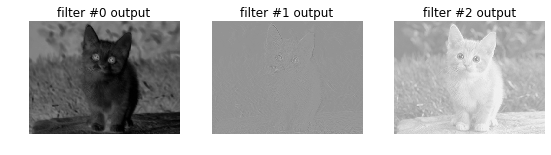

In [3]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv'].data.min(), net.blobs['conv'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

Raising the bias of a filter will correspondingly raise its output:

In [4]:
# pick first filter output
conv0 = net.blobs['conv'].data[0, 0]
print("pre-surgery output mean {:.2f}".format(conv0.mean()))
# set first filter bias to 1
net.params['conv'][1].data[0] = 1.
net.forward()
print("post-surgery output mean {:.2f}".format(conv0.mean()))

pre-surgery output mean -0.02
post-surgery output mean 0.98


Altering the filter weights is more exciting since we can assign any kernel like Gaussian blur, the Sobel operator for edges, and so on. The following surgery turns the 0th filter into a Gaussian blur and the 1st and 2nd filters into the horizontal and vertical gradient parts of the Sobel operator.

See how the 0th output is blurred, the 1st picks up horizontal edges, and the 2nd picks up vertical edges.

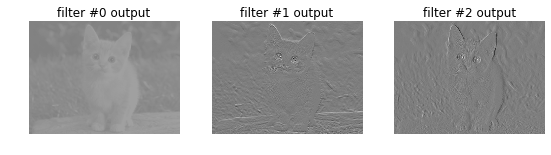

In [5]:
ksize = net.params['conv'][0].data.shape[2:]
# make Gaussian blur
sigma = 1.
y, x = np.mgrid[-ksize[0]//2 + 1:ksize[0]//2 + 1, -ksize[1]//2 + 1:ksize[1]//2 + 1]
g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
gaussian = (g / g.sum()).astype(np.float32)
net.params['conv'][0].data[0] = gaussian
# make Sobel operator for edge detection
net.params['conv'][0].data[1:] = 0.
sobel = np.array((-1, -2, -1, 0, 0, 0, 1, 2, 1), dtype=np.float32).reshape((3,3))
net.params['conv'][0].data[1, 0, 1:-1, 1:-1] = sobel  # horizontal
net.params['conv'][0].data[2, 0, 1:-1, 1:-1] = sobel.T  # vertical
show_filters(net)

With net surgery, parameters can be transplanted across nets, regularized by custom per-parameter operations, and transformed according to your schemes.

## Casting a Classifier into a Fully Convolutional Network

Let's take the standard Caffe Reference ImageNet model "CaffeNet" and transform it into a fully convolutional net for efficient, dense inference on large inputs. This model generates a classification map that covers a given input size instead of a single classification. In particular a 8 $\times$ 8 classification map on a 451 $\times$ 451 input gives 64x the output in only 3x the time. The computation exploits a natural efficiency of convolutional network (convnet) structure by amortizing the computation of overlapping receptive fields.

To do so we translate the `InnerProduct` matrix multiplication layers of CaffeNet into `Convolutional` layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The `fc6` inner product when carried out as convolution by `fc6-conv` turns into a 6 $\times$ 6 filter with stride 1 on `pool5`. Back in image space this gives a classification for each 227 $\times$ 227 box with stride 32 in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1, and work out the indexing details for a clear understanding.

In [6]:
!diff net_surgery/bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

1,2c1
< # Fully convolutional network version of CaffeNet.
< name: "CaffeNetConv"
---
> name: "CaffeNet"
7,11c6
<   input_param {
<     # initial shape for a fully convolutional network:
<     # the shape can be set for each input by reshape.
<     shape: { dim: 1 dim: 3 dim: 451 dim: 451 }
<   }
---
>   input_param { shape: { dim: 10 dim: 3 dim: 227 dim: 227 } }
157,158c152,153
<   name: "fc6-conv"
<   type: "Convolution"
---
>   name: "fc6"
>   type: "InnerProduct"
160,161c155,156
<   top: "fc6-conv"
<   convolution_param {
---
>   top: "fc6"
>   inner_product_param {
163d157
<     kernel_size: 6
169,170c163,164
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
175,176c169,170
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
182,186c176,180
<   name: "fc7-conv"
<   type: "Convolution"
<   bottom: "fc6-conv"
<   top: "fc7-conv"
<   convolution_param {
---
>   name: "fc7"
>   type: "InnerProduct"
>   bottom: "fc6"
>   top: "f

The only differences needed in the architecture are to change the fully connected classifier inner product layers into convolutional layers with the right filter size -- 6 x 6, since the reference model classifiers take the 36 elements of `pool5` as input -- and stride 1 for dense classification. Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model.

In [7]:
# Load the original network and extract the fully connected layers' parameters.
net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)
params = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

fc6 weights are (4096, 9216) dimensional and biases are (4096,) dimensional
fc7 weights are (4096, 4096) dimensional and biases are (4096,) dimensional
fc8 weights are (1000, 4096) dimensional and biases are (1000,) dimensional


Consider the shapes of the inner product parameters. The weight dimensions are the output and input sizes while the bias dimension is the output size.

In [8]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6-conv weights are (4096, 256, 6, 6) dimensional and biases are (4096,) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional and biases are (4096,) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional and biases are (1000,) dimensional


The convolution weights are arranged in output $\times$ input $\times$ height $\times$ width dimensions. To map the inner product weights to convolution filters, we could roll the flat inner product vectors into channel $\times$ height $\times$ width filter matrices, but actually these are identical in memory (as row major arrays) so we can assign them directly.

The biases are identical to those of the inner product.

Let's transplant!

In [9]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

Next, save the new model weights.

In [10]:
net_full_conv.save('net_surgery/bvlc_caffenet_full_conv.caffemodel')

To conclude, let's make a classification map from the example cat image and visualize the confidence of "tiger cat" as a probability heatmap. This gives an 8-by-8 prediction on overlapping regions of the 451 $\times$ 451 input.

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


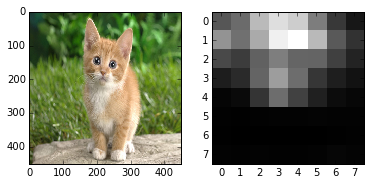

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])

The classifications include various cats -- 282 = tiger cat, 281 = tabby, 283 = persian -- and foxes and other mammals.

In this way the fully connected layers can be extracted as dense features across an image (see `net_full_conv.blobs['fc6'].data` for instance), which is perhaps more useful than the classification map itself.

Note that this model isn't totally appropriate for sliding-window detection since it was trained for whole-image classification. Nevertheless it can work just fine. Sliding-window training and finetuning can be done by defining a sliding-window ground truth and loss such that a loss map is made for every location and solving as usual. (This is an exercise for the reader.)

*A thank you to Rowland Depp for first suggesting this trick.*